In [1]:
##### Using Measurements to Calcuate Error in Local Clock Time for Nodes #####

####################
# IMPORT LIBRARIES #
####################

import numpy as np
from colorama import Fore, Style
import matplotlib.pyplot as plt
import math
import itertools

In [2]:
####################
# DEFINE FUNCTIONS #
####################

def make_delta(col_num, links):
    file_name = "col_" + str(col_num) + ".txt"
    d = 0
    delta = np.zeros((len(links),1))

    with open(file_name,'r') as f:
        vals = f.readlines()
    
    for val in vals:
        val = val.replace(",\n", "")
        delta[d] = (int(val))
        d += 1
    return delta

def find_e_vector(delta):
    estimate = np.dot(pinvA, delta)

    e_est = estimate[:len(rx_names)]
    T_est = estimate[len(rx_names):]
    return e_est, T_est, estimate

def print_results(col_num, rx_names, e_est, T_est):
    print(" ---------- column (repNum) " + str(col_num) + " in delta.txt ---------- ")
    print(Fore.RED + "(~, rx_name ) -----    e_estimate    -----   T_estimate" + Style.RESET_ALL)
    r = 0

    for rx in rx_names:
        rx_temp = rx
        if len(rx) != len("browning"):
            for i in range(len("browning")-len(rx)):
                rx_temp += " "
        if e_est[r][0] < 0 or T_est[r][0] < 0:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.7f') + "]  ----- [" + 
                  format(T_est[r][0],'.7f') + ']')
        else:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.8f') + "]  ----- [" + 
                  format(T_est[r][0],'.8f') + ']')
        r += 1

def least_sq_error(col_num, estimate, delta):
    # error / noise calculation for each link
    est_delta = np.dot(A,estimate)
    error = abs(delta - est_delta)
    
    i = np.array([*range(len(links))]).reshape(len(links),1)
    
    # plotting error for each link
    print(' ----- Plotting Link Error for Column ' + str(col_num) + ' ----- ')
    plt.plot(i,error)
    plt.grid()
    plt.xlabel('Link Number')
    plt.ylabel('Delta Estimation Error (Noise)')
    plt.title('Estimation Error/Noise by Link for Column ' + str(col_num))
    plt.show()
    
    # finding root mean squared error for repNum (col_num)
    print(' ----- Root Mean Squared Error for Column ' + str(col_num) + ' ----- ')
    RMSE = math.sqrt(np.square(error).mean())
    print(RMSE)
    print('\n')
    return RMSE

def round_string(RMSE):
    round_i = 6
    while(len(str(RMSE)) > len('column #')):
        RMSE = round(RMSE,round_i)
        round_i -= 1
    return RMSE

def correct_difference(col_num, delta):
    s = 0
    while s < 7:
        section = delta[s*(len(rx_names)-1):(s+1)*(len(rx_names)-1)]
        small = []
        lag_ind = 0
        for lag in section:
            ind = 0
            while(ind < 6):
                if abs(lag - section[ind]) > 2000:
                    min_val = min(lag, section[ind])[0]
                    if min_val == lag:
                        small.append([lag_ind,min_val])
                    else:
                        small.append([ind,min_val])
                ind += 1
            lag_ind += 1
        
        small.sort()
        small = list(small for small,_ in itertools.groupby(small))
        for sm in small:
            print('Column '+str(col_num)+', Section '+str(s)+', Index '+str(sm[0])+' -- '+str(sm[1]))
            delta[(sm[0] + s*6)] += 4096
        s += 1
    return delta


In [3]:
####################
# SETTING UP LINKS #
####################

rx_names = ["bes","browning","fm","honors","hospital","smt","ustar"]
links_names = ["bes-browning","bes-fm","bes-honors","bes-hospital","bes-smt","bes-ustar",
         "browning-bes","browning-fm","browning-honors","browning-hospital","browning-smt","browning-ustar",
         "fm-bes","fm-browning","fm-honors","fm-hospital","fm-smt","fm-ustar",
         "honors-bes","honors-browning","honors-fm","honors-hospital","honors-smt","honors-ustar",
         "hospital-bes","hospital-browning","hospital-fm","hospital-honors","hospital-smt","hospital-ustar",
         "smt-bes","smt-browning","smt-fm","smt-honors","smt-hospital","smt-ustar",
         "ustar-bes","ustar-browning","ustar-fm","ustar-honors","ustar-hospital","ustar-smt"]
links = []

for pair in links_names:
    pair = pair.split("-")
    links.append(pair)

print(" ----- all node links ----- ")
print(links)

 ----- all node links ----- 
[['bes', 'browning'], ['bes', 'fm'], ['bes', 'honors'], ['bes', 'hospital'], ['bes', 'smt'], ['bes', 'ustar'], ['browning', 'bes'], ['browning', 'fm'], ['browning', 'honors'], ['browning', 'hospital'], ['browning', 'smt'], ['browning', 'ustar'], ['fm', 'bes'], ['fm', 'browning'], ['fm', 'honors'], ['fm', 'hospital'], ['fm', 'smt'], ['fm', 'ustar'], ['honors', 'bes'], ['honors', 'browning'], ['honors', 'fm'], ['honors', 'hospital'], ['honors', 'smt'], ['honors', 'ustar'], ['hospital', 'bes'], ['hospital', 'browning'], ['hospital', 'fm'], ['hospital', 'honors'], ['hospital', 'smt'], ['hospital', 'ustar'], ['smt', 'bes'], ['smt', 'browning'], ['smt', 'fm'], ['smt', 'honors'], ['smt', 'hospital'], ['smt', 'ustar'], ['ustar', 'bes'], ['ustar', 'browning'], ['ustar', 'fm'], ['ustar', 'honors'], ['ustar', 'hospital'], ['ustar', 'smt']]


In [4]:
####################
# SETTING UP A     #
####################

A = np.zeros((len(links),2*len(rx_names)))

# delta is a vector of the sample number of the start of the sync in the recieved signal
link_num = 0
for link in links:
    # each link is a (tx_name, rx_name)
    tx_num = rx_names.index(link[0])
    rx_num = rx_names.index(link[1])
    A[link_num,tx_num] = 1
    A[link_num,len(rx_names)+tx_num] = 1
    A[link_num,rx_num] = -1
    link_num += 1

print(" ----- A matrix ----- ")
# print(A)

 ----- A matrix ----- 


In [5]:
####################
# FIND PEUSDO-INV  #
####################

pinvA = np.linalg.pinv(A)

print(" ----- peusdoinverse A ----- ")
# print(pinvA)

 ----- peusdoinverse A ----- 


In [6]:
####################
# MAKE DELTA VECS  #
####################

delta_1 = make_delta(1,links)
delta_2 = make_delta(2,links)
delta_3 = make_delta(3,links)
delta_4 = make_delta(4,links)

In [7]:
####################
# CORRECT ERR EST  #
####################

print(' ----- Values to Correct ----- ')
delta_1 = correct_difference(1,delta_1)
delta_2 = correct_difference(2,delta_2)
delta_3 = correct_difference(3,delta_3)
delta_4 = correct_difference(4,delta_4)

 ----- Values to Correct ----- 
Column 2, Section 5, Index 2 -- 737.0
Column 3, Section 5, Index 2 -- 936.0


In [8]:
####################
# RUNNING ALL COLS #
####################

e_est_1, T_est_1, estimate_1 = find_e_vector(delta_1)
e_est_2, T_est_2, estimate_2 = find_e_vector(delta_2)
e_est_3, T_est_3, estimate_3 = find_e_vector(delta_3)
e_est_4, T_est_4, estimate_4 = find_e_vector(delta_4)

In [9]:
####################
# PRINTING COLS    #
####################

print_results(1, rx_names, e_est_1, T_est_1)
print('\n ------------------------------ \n')

print_results(2, rx_names, e_est_2, T_est_2)
print('\n ------------------------------ \n')

print_results(3, rx_names, e_est_3, T_est_3)
print('\n ------------------------------ \n')

print_results(4, rx_names, e_est_4, T_est_4)
print('\n ------------------------------ \n')

 ---------- column (repNum) 1 in delta.txt ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [131.74285714]  ----- [2728.96666667]
(~, browning) -----  [133.40000000]  ----- [1813.36666667]
(~, fm      ) -----  [-797.4571429]  ----- [1894.3666667]
(~, honors  ) -----  [133.42857143]  ----- [1952.16666667]
(~, hospital) -----  [133.17142857]  ----- [953.96666667]
(~, smt     ) -----  [131.74285714]  ----- [1201.96666667]
(~, ustar   ) -----  [133.97142857]  ----- [2374.36666667]

 ------------------------------ 

 ---------- column (repNum) 2 in delta.txt ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [133.37142857]  ----- [2935.23333333]
(~, browning) -----  [133.37142857]  ----- [2024.23333333]
(~, fm      ) -----  [-800.0857143]  ----- [4569.4333333]
(~, honors  ) -----  [136.25714286]  ----- [2158.03333333]
(~, hospital) -----  [131.62857143]  ----- [1166.43333333]
(~, smt     ) -----  [131.08571429]  -

 ----- Plotting Link Error for Column 1 ----- 


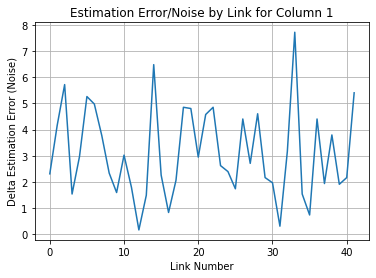

 ----- Root Mean Squared Error for Column 1 ----- 
3.5444856728173213


 ----- Plotting Link Error for Column 2 ----- 


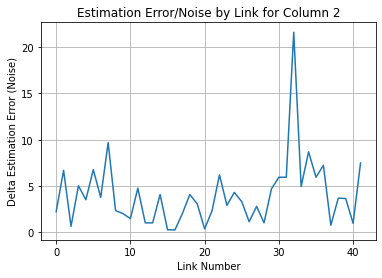

 ----- Root Mean Squared Error for Column 2 ----- 
5.453212662703654


 ----- Plotting Link Error for Column 3 ----- 


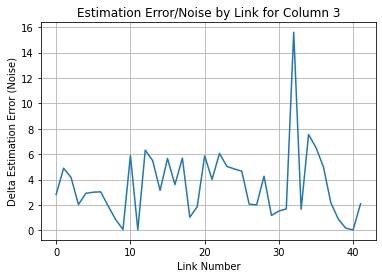

 ----- Root Mean Squared Error for Column 3 ----- 
4.501851470969116


 ----- Plotting Link Error for Column 4 ----- 


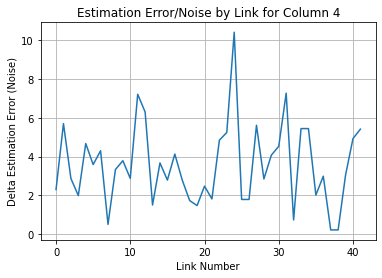

 ----- Root Mean Squared Error for Column 4 ----- 
4.148067331304319




In [10]:
####################
# LEAST SQUARE ERR #
####################

RMSE_1 = least_sq_error(1,estimate_1,delta_1)
RMSE_2 = least_sq_error(2,estimate_2,delta_2)
RMSE_3 = least_sq_error(3,estimate_3,delta_3)
RMSE_4 = least_sq_error(4,estimate_4,delta_4)

column 1 ----- column 2 ----- column 3 ----- column 4
3.544486 ----- 5.453213 ----- 4.501851 ----- 4.148067


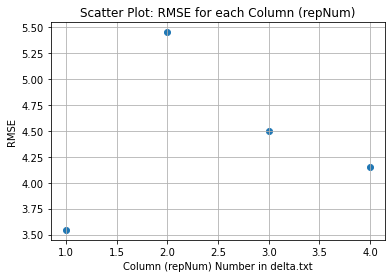

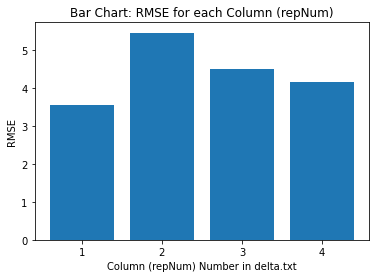

In [11]:
####################
# PRINTING COLS    #
####################

RMSE_1 = round_string(RMSE_1)
RMSE_2 = round_string(RMSE_2)
RMSE_3 = round_string(RMSE_3)
RMSE_4 = round_string(RMSE_4)

print(Fore.RED + "column 1 ----- column 2 ----- column 3 ----- column 4" + Style.RESET_ALL)
print(str(RMSE_1) + ' ----- ' + str(RMSE_2) + ' ----- ' + str(RMSE_3) + ' ----- ' + str(RMSE_4))

plt.scatter(np.array([1,2,3,4]),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.grid()
plt.xlabel('Column (repNum) Number in delta.txt')
plt.ylabel('RMSE')
plt.title('Scatter Plot: RMSE for each Column (repNum)')
plt.show()

plt.bar(np.array(['1','2','3','4']),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.xlabel('Column (repNum) Number in delta.txt')
plt.ylabel('RMSE')
plt.title('Bar Chart: RMSE for each Column (repNum)')
plt.show()